# 비대칭 데이터 문제
- https://imbalanced-learn.org/stable/over_sampling.html
-https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import numpy as np
import pandas as pd

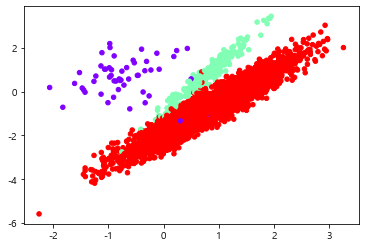

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='rainbow')

## SMOTE
- 가우시안 나이브 등과 같은 알고리즘은 Class weight 파라미터가 없음

In [3]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print(f'normal data distribution: {Counter(y)}')
X_smote, y_smote = SMOTE().fit_resample(X,y)
print(f'SMOTE data distribution: {Counter(y_smote)}')

normal data distribution: Counter({2: 4674, 1: 262, 0: 64})
SMOTE data distribution: Counter({2: 4674, 1: 4674, 0: 4674})


## 원래 데이터로 예측

In [4]:
from sklearn import model_selection, metrics
from imblearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
clf = LinearSVC()
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=11)
model_selection.cross_validate(clf, X, y, scoring='recall_macro', cv=kf)
model_selection.cross_val_score(clf, X, y, scoring='recall_macro', cv=kf)

{'fit_time': array([0.1172328 , 0.09041357, 0.07172179]),
 'score_time': array([0.00421548, 0.00418854, 0.00299001]),
 'test_score': array([0.69340238, 0.56378601, 0.59348149])}

array([0.69340238, 0.56378601, 0.59348149])

## Data over-under-combine

In [5]:
from imblearn.over_sampling import *
oversamplers = [RandomOverSampler(random_state=0), ADASYN(random_state=0),
                SMOTE(random_state=42)]
for sampler in oversamplers :
    imba_pipeline= make_pipeline(sampler, clf)
    model_selection.cross_val_score(imba_pipeline, X, y, scoring='recall_macro', cv=kf)

array([0.8378122 , 0.82726718, 0.82383264])

array([0.53418115, 0.5825033 , 0.71177491])

array([0.84221685, 0.83272696, 0.82319038])

In [6]:
borderline_smote = [BorderlineSMOTE(random_state=13), SVMSMOTE(random_state=11)]
for sampler in borderline_smote :
    imba_pipeline= make_pipeline(sampler, clf)
    model_selection.cross_val_score(imba_pipeline, X, y, scoring='recall_macro', cv=kf)

array([0.82447722, 0.86502517, 0.87378737])

array([0.8946434 , 0.91022688, 0.88909526])

In [7]:
from imblearn.under_sampling import *
undersamplers = [RandomUnderSampler(), TomekLinks(), OneSidedSelection()]
for sampler in undersamplers :
    imba_pipeline= make_pipeline(sampler, clf)
    model_selection.cross_val_score(imba_pipeline, X, y, scoring='recall_macro', cv=kf)

array([0.83845611, 0.81662653, 0.81612551])

array([0.71716125, 0.57201646, 0.61246442])

array([0.71716125, 0.78432473, 0.66941322])

In [8]:
from imblearn.combine import *
combinesamplers = [SMOTEENN(random_state=0), SMOTETomek(random_state=4)]
for sampler in combinesamplers :
    imba_pipeline= make_pipeline(sampler, clf)
    model_selection.cross_val_score(imba_pipeline, X, y, scoring='recall_macro', cv=kf)

array([0.86445475, 0.86012321, 0.83558527])

array([0.84414859, 0.83571076, 0.82468899])

# Ensemble of samplers
## Classifier including inner balancing samplers
https://imbalanced-learn.org/stable/ensemble.html
###  Bagging classifier

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier

bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=0) 
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0)

for classifier in [bag, brf, rusboost] :
    model_selection.cross_val_score(classifier, X, y, scoring='recall_macro', cv=kf)

array([0.86744119, 0.88333391, 0.85821205])

array([0.88380873, 0.88856932, 0.85341355])

array([0.70236924, 0.50233915, 0.5361327 ])

# 데이터 제거

In [10]:
from sklearn.datasets import fetch_openml
data = fetch_openml(name='CreditCardFraudDetection')
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df['log_Amount'] = np.log(1+df['Amount'])
data = df.sample(frac=0.1, random_state=135).copy()
data.head()
data.shape
data.target.value_counts(normalize=True)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,target,log_Amount
206709,136330.0,2.108286,-0.020359,-2.234273,-0.124080,0.559843,-1.315913,0.631887,-0.385490,0.150628,...,0.519705,-0.091751,-0.379542,0.418822,0.248646,-0.098857,-0.094773,7.70,0.0,2.163323
164567,116819.0,2.080143,-0.075408,-1.359381,0.261263,0.232201,-0.797886,0.233487,-0.330165,0.493154,...,-0.784150,0.233078,-0.636937,-0.191137,0.234986,-0.070648,-0.062794,17.99,0.0,2.943913
16546,27917.0,1.152650,0.204938,0.441832,1.211595,-0.254895,-0.383380,-0.004286,-0.019590,0.085094,...,0.209828,-0.054351,0.058103,0.515330,-0.299402,0.032551,0.022865,21.00,0.0,3.091042
152705,97443.0,-0.389692,0.410148,0.616187,-0.686644,1.040312,-0.322199,0.523625,-0.037453,1.319237,...,0.685267,-0.182303,0.767857,-0.242738,0.009678,0.115370,0.176041,6.60,0.0,2.028148
10646,17920.0,-1.306986,0.183306,3.164803,0.810135,1.529576,2.388322,0.551279,-0.054401,1.675481,...,0.556523,0.146513,-1.128693,-0.633623,-0.454903,-0.826329,-0.826186,4.95,0.0,1.783391


(28481, 32)

0.0    0.998139
1.0    0.001861
Name: target, dtype: float64

In [11]:
X= data[['log_Amount','V1', 'V3', 'V5']]
y= data['target']
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=11)
recall_score = []
for seed in np.random.choice(100, 10):
    np.random.seed(seed)
    recall_score.append(model_selection.cross_val_score(clf, X, y,  #
                                                        scoring='recall', cv=kf).mean())

<Figure size 864x216 with 0 Axes>

<BarContainer object of 10 artists>

10회(5회 교차검증) 평균재현율:0.08752136752136751


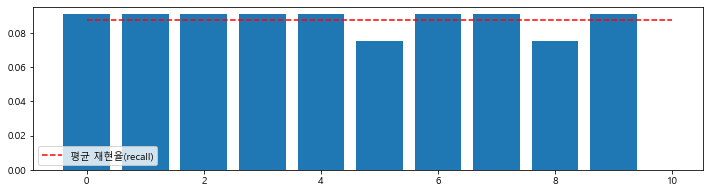

In [12]:
plt.rcParams['font.family']='Malgun Gothic'
plt.figure(figsize=(12,3))
plt.bar(np.arange(10), recall_score)
mean = np.mean(recall_score)
print(f'10회(5회 교차검증) 평균재현율:{mean}')
plt.plot([0, 10], [mean, mean], 'r--', label='평균 재현율(recall)'); plt.legend()

<AxesSubplot:xlabel='target', ylabel='log_Amount'>

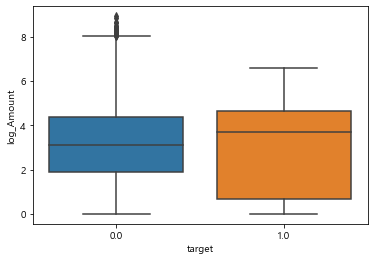

In [13]:
import seaborn as sns
sns.boxplot(x= 'target', y= 'log_Amount', data= data)

In [14]:
max = data[data['target'] == 1]['log_Amount'].max()
data.loc[data['log_Amount'] > max]['target'].value_counts()
print(f'log_Amount 변수값이 {max:.3f}이상이면 항상 적합')
data = data.loc[data['log_Amount'] <= max]
data.shape

0.0    521
Name: target, dtype: int64

log_Amount 변수값이 6.585이상이면 항상 적합


(27960, 32)

In [15]:
data.target.value_counts(normalize=True)

0.0    0.998104
1.0    0.001896
Name: target, dtype: float64

In [16]:
data.target.value_counts(normalize=True)
X= data[['log_Amount','V1', 'V3', 'V5']]
y= data['target']
recall_score = []
for seed in np.random.choice(100, 10):
    np.random.seed(seed)
    recall_score.append(model_selection.cross_val_score(clf, X, y,  #
                                                        scoring='recall', cv=kf).mean())

0.0    0.998104
1.0    0.001896
Name: target, dtype: float64

<Figure size 864x216 with 0 Axes>

<BarContainer object of 10 artists>

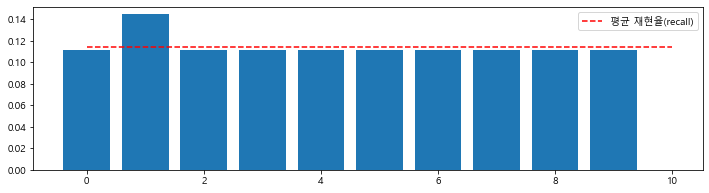

In [17]:
plt.figure(figsize=(12,3))
plt.bar(np.arange(10), recall_score)
mean = np.mean(recall_score)
plt.plot([0, 10], [mean, mean], 'r--', label='평균 재현율(recall)')
plt.legend()

# End